<a href="https://colab.research.google.com/github/SchrodingersSangru/Arbitrary-HHL/blob/main/portfolio_optimizaton_using_hhl_algo_using_the_formulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Portfolio optimization using HHL algorithm
In this section, let us calculate the optimal portfolio (asset allocation) based on the data of past stock price fluctuations, referring to the paper [1].
Portfolio optimization is one of the problems that is expected to be solved faster than before by using the HHL algorithm.
Specifically, this notebook considers the problem of what kind of asset allocation will give the highest return with the lowest risk when investing in stocks of five Indian tech startups.
This notebook is built upon the tutorial notebook at Qulacs' Github which is available [here]().

### Stock Price Data Acquisition
First, we obtain the stock price data of each company.

* Use daily data of 5 Indian stocks
* To obtain stock price data, use pandas_datareader to obtain from Yahoo! Finance database.
* Adjusted closing price in INR is used for the stock price.

In [19]:
# Install pandas, pandas_datareader required for data acquisition
!pip install pandas pandas_datareader

In [20]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

In [21]:
import yfinance as yf
import pandas as pd

# Issue Selection
codes = ['FINOPB.NS', 'CARTRADE.NS', 'ZOMATO.NS', 'EASEMYTRIP.NS', 'POLICYBZR.NS'] # Five Indian stocks

# Using one year of data from 2022
start = "2022-01-01"
end = "2022-12-31"

# Create an empty DataFrame
df = pd.DataFrame()

# Loop over the stock symbols
for code in codes:
    # Fetch the historical stock price data
    data = yf.download(code, start=start, end=end)
    # Store the adjusted closing prices in the DataFrame
    df[code] = data['Adj Close']


# Display the most recent data
df.tail()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,FINOPB.NS,CARTRADE.NS,ZOMATO.NS,EASEMYTRIP.NS,POLICYBZR.NS
Date,,,,,
2022-12-26,242.000000,463.549988,58.150002,54.650002,456.899994
2022-12-27,254.649994,458.799988,58.950001,55.049999,465.049988
2022-12-28,250.949997,467.000000,60.150002,55.250000,460.600006
2022-12-29,253.750000,461.450012,60.849998,53.500000,453.899994
2022-12-30,253.050003,468.649994,59.299999,52.700001,448.299988


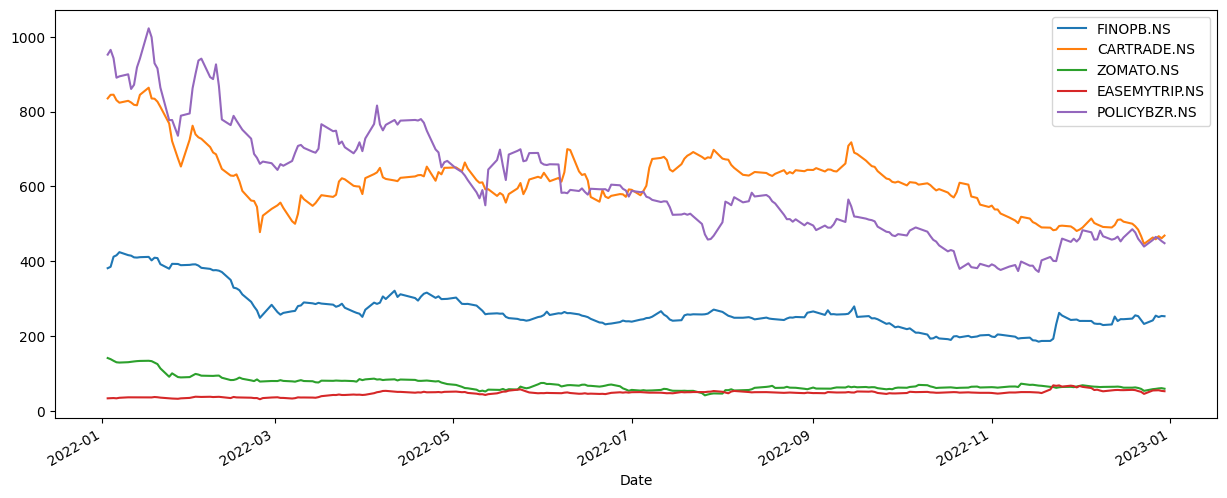

In [22]:
import matplotlib.pyplot as plt

# Plot the stock price
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
df.loc[:,['FINOPB.NS', 'CARTRADE.NS', 'ZOMATO.NS', 'EASEMYTRIP.NS', 'POLICYBZR.NS']].plot(ax=axes)
plt.show()

### Data Preprocessing
Next, the acquired stock prices are converted to daily returns to obtain some statistics.

#### Conversion to Daily Returns
The daily return (rate of change) $y_t$ (where $t$ is the date) of an individual stock is defined as follows

$$
y_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

This is obtained with the `pct_change()` method of the `pandas DataFrame`.

In [23]:
daily_return = df.pct_change()
display(daily_return.tail())

,FINOPB.NS,CARTRADE.NS,ZOMATO.NS,EASEMYTRIP.NS,POLICYBZR.NS
Date,,,,,
2022-12-26,0.040860,0.038302,0.083877,0.199781,0.040064
2022-12-27,0.052273,-0.010247,0.013758,0.007319,0.017838
2022-12-28,-0.014530,0.017873,0.020356,0.003633,-0.009569
2022-12-29,0.011158,-0.011884,0.011638,-0.031674,-0.014546
2022-12-30,-0.002759,0.015603,-0.025472,-0.014953,-0.012338


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2022-01-03 to 2022-12-30
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FINOPB.NS      248 non-null    float64
 1   CARTRADE.NS    248 non-null    float64
 2   ZOMATO.NS      248 non-null    float64
 3   EASEMYTRIP.NS  248 non-null    float64
 4   POLICYBZR.NS   248 non-null    float64
dtypes: float64(5)
memory usage: 11.6 KB


#### Expected Returns
Find the expected return $\vec R$ for each stock. Here we use the arithmetic mean of the historical returns:

$$
\vec R = \frac{1}{T} \sum_{t= 1}^{T} \vec y_t
$$

In [25]:
expected_return = daily_return.dropna(how='all').mean() * 252 # Multiply by 252 annual operating days for annualization
print(expected_return)

FINOPB.NS       -0.298387
CARTRADE.NS     -0.485177
ZOMATO.NS       -0.658962
EASEMYTRIP.NS    0.636052
POLICYBZR.NS    -0.601463
dtype: float64


#### Variance/Covariance Matrix
The sample unbiased variance/covariance matrix $\Sigma$ of the returns is defined by

$$
\Sigma = \frac{1}{T-1} \sum_{t=1}^{T} ( \vec y_t -\vec R ) (\vec y_t -\vec R )^T
$$

In [26]:
cov = daily_return.dropna(how='all').cov() * 252 # For annualized basis
display(cov)

,FINOPB.NS,CARTRADE.NS,ZOMATO.NS,EASEMYTRIP.NS,POLICYBZR.NS
FINOPB.NS,0.247652,0.062317,0.052448,0.064117,0.043996
CARTRADE.NS,0.062317,0.209135,0.087491,0.080923,0.072094
ZOMATO.NS,0.052448,0.087491,0.453537,0.092713,0.184897
EASEMYTRIP.NS,0.064117,0.080923,0.092713,0.371751,0.086758
POLICYBZR.NS,0.043996,0.072094,0.184897,0.086758,0.338086


### Portfolio Optimization
Now that we are ready, let's tackle portfolio optimization.

First, the portfolio (i.e., asset allocation) is represented by a 4-component vector $\vec{w} = (w_0,w_1,w_2,w_3)^T$.
For example, if $\vec{w}=(1,0,0,0)$, it means a portfolio with 100% of its assets invested in Google stock.

Let us consider a portfolio that satisfies the following equation.

$$
\min_{\vec{w}} \frac{1}{2} \vec{w}^T \Sigma \vec{w} \:\:\: \text{s.t.} \:\: \vec R^T \vec w = \mu , \: \vec 1^T \vec w =1
$$

This formula means

* "minimizing the variance of the portfolio's return"

under the following condition

* "The expected return (average of returns) of the portfolio is $\mu$"
* "the sum of the weights invested in the portfolio is 1" ($\vec 1 = (1,1,1,1)^T$)

In other words, the best portfolio is the one that minimizes the variance (risk) of the desired future return of only $\mu$ as much as possible. Such a problem setup is called [Markowitz's mean-variance approach](https://en.wikipedia.org/wiki/Modern_portfolio_theory) and is one of the foundational ideas of modern financial engineering.

Using Lagrange's undetermined multiplier method, $\vec{w}$ satisfying the above conditions can be obtained by solving the linear equation

$$
\begin{gather}
W
\left(
\begin{array}{c}
\eta \\
\theta \\
\vec w
\end{array}
\right)
=
\left(
\begin{array}{c}
 \mu \\
 1 \\
\vec 0
\end{array}
\right),  \tag{1}\\
W =
\left(
\begin{array}{ccc}
0 & 0 & \vec R^T \\
0 & 0 & \vec 1^T \\
\vec{R} &\vec 1 & \Sigma
\end{array}
\right)
\end{gather}
$$

where $\eta, \theta$ are the parameters of Lagrange's undetermined multiplier method.
Therefore, to find the optimal portfolio $\vec w$, we can solve the simultaneous equation (1) for $\vec w$.
We have now attributed the portfolio optimization problem to a linear equation for which the HHL algorithm can be used.

#### Creating the matrix W

In [27]:
R = expected_return.values
Pi = np.ones(5)
S = cov.values

row1 = np.append(np.zeros(2), R).reshape(1,-1)
row2 = np.append(np.zeros(2), Pi).reshape(1,-1)
row3 = np.concatenate([R.reshape(-1,1), Pi.reshape(-1,1), S], axis=1)
W = np.concatenate([row1, row2, row3])

np.set_printoptions(linewidth=200)
print(W)

[[ 0.          0.         -0.29838734 -0.48517697 -0.65896155  0.63605219 -0.60146348]
 [ 0.          0.          1.          1.          1.          1.          1.        ]
 [-0.29838734  1.          0.24765153  0.06231686  0.0524475   0.06411737  0.04399635]
 [-0.48517697  1.          0.06231686  0.20913529  0.08749071  0.08092259  0.07209397]
 [-0.65896155  1.          0.0524475   0.08749071  0.4535369   0.09271271  0.18489656]
 [ 0.63605219  1.          0.06411737  0.08092259  0.09271271  0.37175062  0.08675818]
 [-0.60146348  1.          0.04399635  0.07209397  0.18489656  0.08675818  0.33808559]]


In [28]:
## Check eigenvalue of W -> fits in [-pi, pi]
print(np.linalg.eigh(W)[0])

[-2.04650994 -0.8713635   0.15988959  0.20277511  0.29711292  1.1791468   2.69910895]


#### Creating the right-hand side vector
Given the expected return $\mu$ of the portfolio below, we can calculate the least risky portfolio that will yield such a return. The $\mu$ can be set freely. In general, the higher the expected return, the greater the risk, but we will use 10% as an example (this is a very bearish one, since it is a time when GAFA stocks are going gangbusters).

In [29]:
mu = 0.1 # Portfolio returns (parameters to be put in hand)
xi = 1.0
mu_xi_0 = np.append(np.array([mu, xi]), np.zeros_like(R)) ## Vector on the right side of equation (1)
print(mu_xi_0)

[0.1 1.  0.  0.  0.  0.  0. ]


#### Extend the matrix so that it can be handled by a quantum system
Since $W$ is 6-dimensional, it is computable in a quantum system with 3 qubits ($2^3 = 8$).
Therefore, we also make a matrix and a vector with the extended two dimensions filled with zeros.

In [30]:
nbit = 3 ## Number of bits used for state
N = 2**nbit

W_enl = np.zeros((N, N)) ## enl stands for enlarged
W_enl[:W.shape[0], :W.shape[1]] = W.copy()
mu_xi_0_enl = np.zeros(N)
mu_xi_0_enl[:len(mu_xi_0)] = mu_xi_0.copy()

We are now ready to solve the simultaneous equation (1).

### Calculating the minimum variance portfolio using the HHL algorithm
Now, let us solve the simultaneous linear equations (1) using the HHL algorithm.
First, as a preliminary step, we prepare the following functions.

* A function `input_state_gate` that returns a quantum circuit that converts the quantum state to $|0\cdots0\rangle \to \sum_i x_i |i \rangle$ according to the classical data $\mathbf{x}$ This function should be built using the qRAM concept, but since we are using a simulator, we will implement it as a non-unitary gate this time. Also, standardization is ignored.)
* Function `CPhaseGate` that returns a control phase gate.
* function `QFT_gate` that returns a gate to perform quantum Fourier transform.

In [53]:
# Install Qulacs
!pip install qulacs

!pip3 install wurlitzer
%load_ext wurlitzer

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


In [54]:
import numpy as np
from qulacs import QuantumCircuit, QuantumState, gate
from qulacs.gate import merge, Identity, H, SWAP

def input_state_gate(start_bit, end_bit, vec):
    """
    Making a quantum gate which transform |0> to \sum_i x[i]|i>m where x[i] is input vector.
    !!! this uses 2**n times 2**n matrix, so it is quite memory-cosuming.
    !!! this gate is not unitary (we assume that the input state is |0>)
    Args:
      int start_bit: first index of qubit which the gate applies
      int end_bit:   last index of qubit which the gate applies
      np.ndarray vec:  input vector.
    Returns:
      qulacs.QuantumGate
    """
    nbit = end_bit - start_bit + 1
    assert vec.size == 2**nbit
    mat_0tox = np.eye(vec.size, dtype=complex)
    mat_0tox[:,0] = vec
    return gate.DenseMatrix(np.arange(start_bit, end_bit+1), mat_0tox)


def CPhaseGate(target, control, angle):
    """
    Create controlled phase gate diag(1,e^{i*angle}) with controll. (Qulacs.gate is requried)

    Args:
      int target:  index of target qubit.
      int control:  index of control qubit.
      float64 angle: angle of phase gate.
    Returns:
      QuantumGateBase.DenseMatrix: diag(1, exp(i*angle)).
    """
    CPhaseGate = gate.DenseMatrix(target, np.array( [[1,0], [0,np.cos(angle)+1.j*np.sin(angle)]])  )
    CPhaseGate.add_control_qubit(control, 1)
    return CPhaseGate

def QFT_gate(start_bit, end_bit, Inverse = False):
    """
    Making a gate which performs quantum Fourier transfromation between start_bit to end_bit.
    (Definition below is the case when start_bit = 0 and end_bit=n-1)
    We associate an integer  j = j_{n-1}...j_0 to quantum state |j_{n-1}...j_0>.
    We define QFT as
    |k> = |k_{n-1}...k_0> = 1/sqrt(2^n) sum_{j=0}^{2^n-1} exp(2pi*i*(k/2^n)*j) |j>.
    then, |k_m > = 1/sqrt(2)*(|0> + exp(i*2pi*0.j_{n-1-m}...j_0)|1> )
    When Inverse=True,  the gate represents Inverse QFT,
    |k> = |k_{n-1}...k_0> = 1/sqrt(2^n) sum_{j=0}^{2^n-1} exp(-2pi*i*(k/2^n)*j) |j>.

    Args:
      int start_bit:  first index of qubits where we apply QFT.
      int end_bit:    last  index of qubits where we apply QFT.
      bool Inverse: When True, the gate perform inverse-QFT ( = QFT^{\dagger}).
    Returns:
      qulacs.QuantumGate: QFT gate which acts on a region between start_bit and end_bit.
    """

    gate = Identity(start_bit) ## make empty gate
    n = end_bit - start_bit + 1  ## size of QFT

    ## loop from j_{n-1}
    for target in range(end_bit, start_bit-1, -1):
        gate = merge(gate, H(target)) ## 1/sqrt(2)(|0> + exp(i*2pi*0.j_{target})|1>)
        for control in range(start_bit, target):
            gate = merge( gate, CPhaseGate(target, control, (-1)**Inverse * 2.*np.pi/2**(target-control+1)) )
    ## perform SWAP between (start_bit + s)-th bit and (end_bit - s)-th bit
    for s in range(n//2):  ## s runs 0 to n//2-1
        gate = merge(gate, SWAP(start_bit + s, end_bit - s))
    ## return final circuit
    return gate

First, set the necessary parameters for the HHL algorithm.
Set the clock register quantum bit number `reg_nbit` to `7` and the coefficient `scale_fac` used for scaling the matrix $W$ to `1` (i.e., do not scale it).
Also, the coefficient $c$ used for the control rotation gate is kept at half of the smallest number of nonzeros that can be represented by the `reg_nbit` bits.

In [55]:
# number of registers used for phase estimation
reg_nbit = 7

## Factor to scale W_enl
scale_fac = 1.0
W_enl_scaled = scale_fac * W_enl

## Minimum value to be assumed as an eigenvalue of W_enl_scaled
## In this case, since the projection succeeds 100%, we set the value as a constant multiple of the minimum value that can be represented by the register.
C = 0.5*(2 * np.pi * (1. / 2**(reg_nbit) ))

The core of the HHL algorithm will be written. In this article, we use the simulator qulacs, so various simplifications have been made.
This is an implementation to get a sense of how the HHL algorithm works.

* The part of preparing the input state $|\mathbf{b}\rangle$ is simplified.
* The part of $e^{iA}$ used in the quantum phase estimation algorithm is the diagonalization of $A$ by a classical computer.
* Control rotation gate that takes inverses is also implemented by a classical computer..
* Measure the projection to the auxiliary bit $|0 \rangle{}_{S}$ and treat only the states where the measurement result `0` is obtained.
(For convenience of implementation, the definition of the action of the control rotation gate is reversed from [section 7-1](7.1_quantum_phase_estimation_detailed.ipynb))

In [56]:
from functools import reduce

## diagonalization. AP = PD <-> A = P*D*P^dag
D, P = np.linalg.eigh(W_enl_scaled)

#####################################
### Create an HHL quantum circuit. Starting from the 0th bit,
### we have the bits in the space where A acts (0th ~ nbit-1th),
### the register bits (nbit th ~ nbit+reg_nbit-1 th), and
### the bits for conditional rotation (nbit+reg_nbit th).
#####################################

total_qubits = nbit + reg_nbit + 1
total_circuit = QuantumCircuit(total_qubits)

## ------ Prepare vector b input to the 0th~(nbit-1)th bit ------
## Normally we should use qRAM algorithm, but here we use our own input gate.
## In qulacs, you can also implement it with state.load(b_enl).
state = QuantumState(total_qubits)
state.set_zero_state()
b_gate = input_state_gate(0, nbit-1, mu_xi_0_enl)
total_circuit.add_gate(b_gate)

## ------- Hadamard gate on register bit -------
for register in range(nbit, nbit+reg_nbit): ## from nbit to nbit+reg_nbit-1
    total_circuit.add_H_gate(register)

## ------- Implement phase estimation -------
## U := e^{i*A*t) and its eigenvalues are diag( {e^{i*2pi*phi_k}}_{k=0, ... N-1)).
## Implement \sum_j |j><j| exp(i*A*t*j) to register bits
for register in range(nbit, nbit+reg_nbit):
    ## Implement U^{2^{register-nbit}}.
    ## Use diagonalized results.
    U_mat = reduce(np.dot,  [P, np.diag(np.exp( 1.j * D * (2**(register-nbit)) )), P.T.conj()]  )
    U_gate = gate.DenseMatrix(np.arange(nbit), U_mat)
    U_gate.add_control_qubit(register, 1) ## add control bit
    total_circuit.add_gate(U_gate)

## ------- Perform inverse QFT to register bits -------
total_circuit.add_gate(QFT_gate(nbit, nbit+reg_nbit-1, Inverse=True))

## ------- multiply conditional rotation -------
## The eigenvalue of A*t corresponding to the register |phi> is l = 2pi * 0. phi = 2pi * (phi / 2**reg_nbit).
## The definition of conditional rotation is (opposite of the text)
## |phi>|0> -> C/(lambda)|phi>|0> + sqrt(1 - C^2/(lambda)^2)|phi>|1>.
## Since this is a classical simulation, the gate is made explicitly.
condrot_mat = np.zeros( (2**(reg_nbit+1), (2**(reg_nbit+1))), dtype=complex)
for index in range(2**reg_nbit):
    lam = 2 * np.pi * (float(index) / 2**(reg_nbit) )
    index_0 = index ## integer which represents |index>|0>
    index_1 = index + 2**reg_nbit ## integer which represents |index>|1>
    if lam >= C:
        if lam >= np.pi: ## Since we have scaled the eigenvalues in [-pi, pi] beforehand, [pi, 2pi] corresponds to a negative eigenvalue
            lam = lam - 2*np.pi
        condrot_mat[index_0, index_0] = C / lam
        condrot_mat[index_1, index_0] =   np.sqrt( 1 - C**2/lam**2 )
        condrot_mat[index_0, index_1] = - np.sqrt( 1 - C**2/lam**2 )
        condrot_mat[index_1, index_1] = C / lam

    else:
        condrot_mat[index_0, index_0] = 1.
        condrot_mat[index_1, index_1] = 1.
## Convert to DenseGate and implement
condrot_gate = gate.DenseMatrix(np.arange(nbit, nbit+reg_nbit+1), condrot_mat)
total_circuit.add_gate(condrot_gate)

## ------- Perform QFT to register bits -------
total_circuit.add_gate(QFT_gate(nbit, nbit+reg_nbit-1, Inverse=False))

## ------- Implement the inverse of phase estimation (U^\dagger = e^{-iAt}) -------
for register in range(nbit, nbit+reg_nbit): ## from nbit to nbit+reg_nbit-1
    ## implement {U^{\dagger}}^{2^{register-nbit}}
    ## use diagonalized results.
    U_mat = reduce(np.dot,  [P, np.diag(np.exp( -1.j* D * (2**(register-nbit)) )), P.T.conj()]  )
    U_gate = gate.DenseMatrix(np.arange(nbit), U_mat)
    U_gate.add_control_qubit(register, 1) ## add a control bit
    total_circuit.add_gate(U_gate)

## ------- act Hadamard gate on register bit -------
for register in range(nbit, nbit+reg_nbit):
    total_circuit.add_H_gate(register)

## ------- Project auxiliary bits to 0. Implemented in qulacs as a non-unitary gate -------
total_circuit.add_P0_gate(nbit+reg_nbit)

#####################################
### Run the HHL quantum circuit and retrieve the result
#####################################
total_circuit.update_quantum_state(state)

## The 0th to (nbit-1)th bit corresponds to the calculation result |x>.
result = state.get_vector()[:2**nbit].real
print(result)
x_HHL = result/C * scale_fac
print(x_HHL)

[-0.00247494 -0.003534    0.00728571  0.0044007  -0.00043018  0.0115807   0.001537    0.        ]
[-0.10083827 -0.14398821  0.29684651  0.17930063 -0.01752731  0.47183999  0.06262289  0.        ]


Comparing the solution `x_HHL` by the HHL algorithm with the solution `x_exact` by diagonalization of the usual classical computation, we can see that they are roughly in agreement. (There are several parameters that determine the accuracy of the HHL algorithm (e.g. `reg_nbit`), so please try changing them and experiment with them).

In [35]:
## Exact solution
x_exact = np.linalg.lstsq(W_enl, mu_xi_0_enl, rcond=0)[0]

print("HHL:  ", x_HHL)
print("exact:", x_exact)
rel_error = np.linalg.norm(x_HHL- x_exact) / np.linalg.norm(x_exact)
print("rel_error", rel_error)

HHL:   [-0.10083827 -0.14398821  0.29684651  0.17930063 -0.01752731  0.47183999  0.06262289  0.        ]
exact: [-0.10423092 -0.14835452  0.29715195  0.17982752 -0.01651577  0.47639209  0.06314421  0.        ]
rel_error 0.011733039127845178


In [36]:
x_HHL

array([-0.10083827, -0.14398821,  0.29684651,  0.17930063, -0.01752731,  0.47183999,  0.06262289,  0.        ])

If we take out only the actual weighting part

In [51]:
w_opt_HHL = x_HHL[2:7]
print(sum(w_opt_HHL))
w_opt_exact = x_exact[2:7]
print(sum(w_opt_exact))
w_opt = pd.DataFrame(np.vstack([w_opt_exact, w_opt_HHL]).T, index=df.columns, columns=['exact', 'HHL'])
w_opt

0.9930827146704323
0.9999999999999992


,exact,HHL
FINOPB.NS,0.297152,0.296847
CARTRADE.NS,0.179828,0.179301
ZOMATO.NS,-0.016516,-0.017527
EASEMYTRIP.NS,0.476392,0.471840
POLICYBZR.NS,0.063144,0.062623


<Axes: >

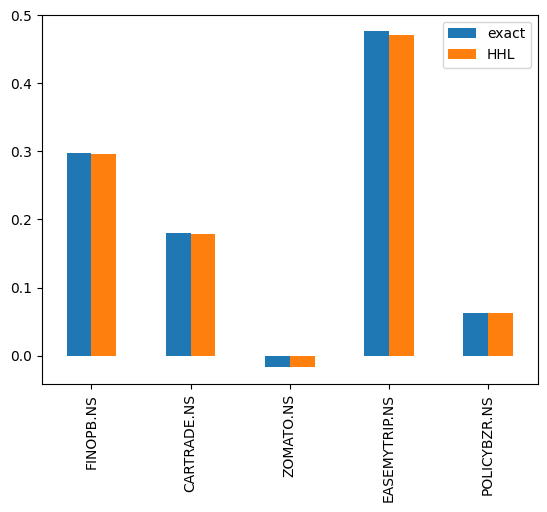

In [38]:
w_opt.plot.bar()


### Appendix: Back Testing
The verification of an investment rule derived from historical data using subsequent data is called "back-testing," and is important for measuring the effectiveness of the investment rule.
In this section, we will observe how much asset values change in the following year, 2023, when invested in a portfolio constructed from 2022 data as described above.

In [39]:
# Using one year data of 2018
start = "2023-01-01"
end = "2023-8-20"

# Create an empty DataFrame
df_t = pd.DataFrame()

# Loop over the stock symbols
for code in codes:
    # Fetch the historical stock price data
    data = yf.download(code, start=start, end=end)
    # Store the adjusted closing prices in the DataFrame
    df_t[code] = data['Adj Close']


display(df_t.tail())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,FINOPB.NS,CARTRADE.NS,ZOMATO.NS,EASEMYTRIP.NS,POLICYBZR.NS
Date,,,,,
2023-08-11,357.700012,527.349976,93.449997,40.349998,727.450012
2023-08-14,351.100006,518.650024,92.750000,40.599998,731.299988
2023-08-16,354.750000,509.549988,91.900002,39.599998,718.599976
2023-08-17,356.450012,496.149994,91.150002,38.450001,710.150024
2023-08-18,356.950012,495.049988,89.349998,37.349998,726.799988


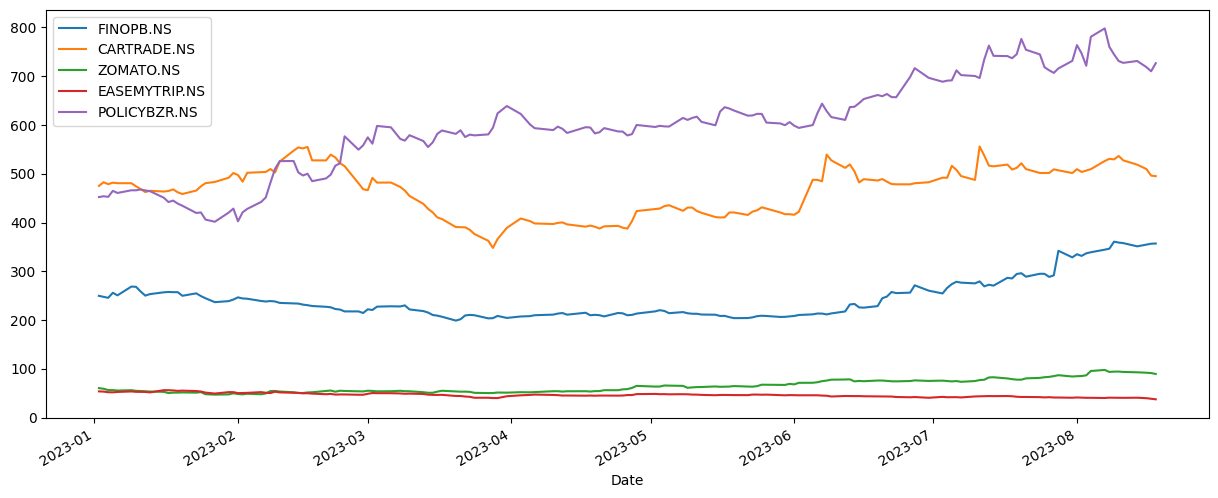

In [40]:
import matplotlib.pyplot as plt

# Plot the stock price
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
df_t.loc[:,['FINOPB.NS', 'CARTRADE.NS', 'ZOMATO.NS', 'EASEMYTRIP.NS', 'POLICYBZR.NS']].plot(ax=axes)
plt.show()

In [41]:
# Changes in portfolio asset values
pf_value = df_t.dot(w_opt)
pf_value.head()

,exact,HHL
Date,,
2023-01-02,212.679694,211.812445
2023-01-03,213.334505,212.466458
2023-01-04,211.365591,210.509462
2023-01-05,215.682455,214.816181
2023-01-06,214.049880,213.185350


In [42]:
# Since the initial amount may differ between exact and HHL, we look at returns normalized by the value at the beginning of the period.
pf_value.exact = pf_value.exact / pf_value.exact[0]
pf_value.HHL = pf_value.HHL / pf_value.HHL[0]
print(pf_value.tail())

               exact       HHL
Date                          
2023-08-11  1.244767  1.244932
2023-08-14  1.229946  1.230071
2023-08-16  1.221407  1.221571
2023-08-17  1.207426  1.207612
2023-08-18  1.209814  1.210003


<Axes: xlabel='Date'>

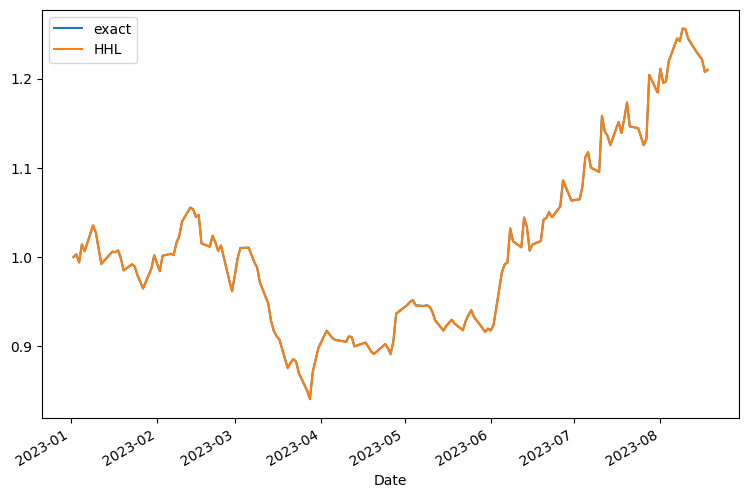

In [43]:
pf_value.plot(figsize=(9, 6))

The stocks of all GAFA companies except Amazon were soft in 2018, resulting in a loss of roughly -20%. The EXACT solution seems to be somewhat better.
Incidentally, since what we originally did was risk minimization, we also calculated the risk for the past year, and the EXACT solution resulted in smaller risk.

In [44]:
pf_value.pct_change().std() * np.sqrt(252) ## annualized

exact    0.259876
HHL      0.260134
dtype: float64

In [45]:
pf_value.pct_change().mean() *252

exact    0.345020
HHL      0.345341
dtype: float64

In [46]:
34.53/ 26.01

1.3275663206459054

In [47]:
!pip install qiskit[all]

In [48]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.algorithms.linear_solvers.matrices import TridiagonalToeplitz
from qiskit.algorithms.linear_solvers.observables import MatrixFunctional

matrix = TridiagonalToeplitz(2, 1, 1 / 3, trotter_steps=2)
right_hand_side = [1.0, -2.1, 3.2, -4.3]
observable = MatrixFunctional(1, 1 / 2)
rhs = right_hand_side / np.linalg.norm(right_hand_side)

# Initial state circuit
num_qubits = matrix.num_state_qubits
qc = QuantumCircuit(num_qubits)
qc.isometry(rhs, list(range(num_qubits)), None)

hhl = HHL()
solution = hhl.solve(matrix, qc, observable)
approx_result = solution.observable

ModuleNotFoundError: ignored

/## Reference
[1] P. Rebentrost and S. Lloyd, “Quantum computational finance: quantum algorithm for portfolio optimization“, https://arxiv.org/abs/1811.03975

In [ ]:
!pip install git+https://github.com/anedumla/quantum_linear_solvers


In [ ]:
import numpy as np
from linear_solvers import NumPyLinearSolver, HHL
matrix = np.array([ [1, -1/3], [-1/3, 1] ])
vector = np.array([1, 0])
naive_hhl_solution = HHL().solve(matrix, vector)
print(naive_hhl_solution)

In [ ]:
classical_solution = NumPyLinearSolver().solve(matrix,
                                               vector/np.linalg.norm(vector))
print(classical_solution)

In [ ]:
from linear_solvers.matrices.tridiagonal_toeplitz import TridiagonalToeplitz
tridi_matrix = TridiagonalToeplitz(1, 1, -1 / 3)
tridi_solution = HHL().solve(tridi_matrix, vector)
tridi_solution

In [ ]:
from qiskit.quantum_info import Statevector

naive_sv = Statevector(naive_hhl_solution.state).data
tridi_sv = Statevector(tridi_solution.state).data

# Extract vector components; 10000(bin) == 16 & 10001(bin) == 17
naive_full_vector = np.array([naive_sv[16], naive_sv[17] ])
tridi_full_vector = np.array([tridi_sv[16], tridi_sv[17] ])

print('naive raw solution vector:', naive_full_vector)
print('tridi raw solution vector:', tridi_full_vector)

In [ ]:
def get_solution_vector(solution):
    """Extracts and normalizes simulated state vector
    from LinearSolverResult."""
    print("solution is", solution)
    solution_vector = Statevector(solution.state).data[16:18].real
    print("solution vector", solution_vector)
    norm = solution.euclidean_norm
    print("norm is", norm)
    return norm * solution_vector / np.linalg.norm(solution_vector)

print('full naive solution vector:', get_solution_vector(naive_hhl_solution))
print('full tridi solution vector:', get_solution_vector(tridi_solution))
print('classical state:', classical_solution.state)